# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [75]:
# Install the required libraries
!pip install prophet

In [3]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [64]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

<ipython-input-64-217fb1a948ac>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [65]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Axes: title={'center': 'Hourly Google Search Traffic for MercadoLibre in May 2020'}, xlabel='Date'>

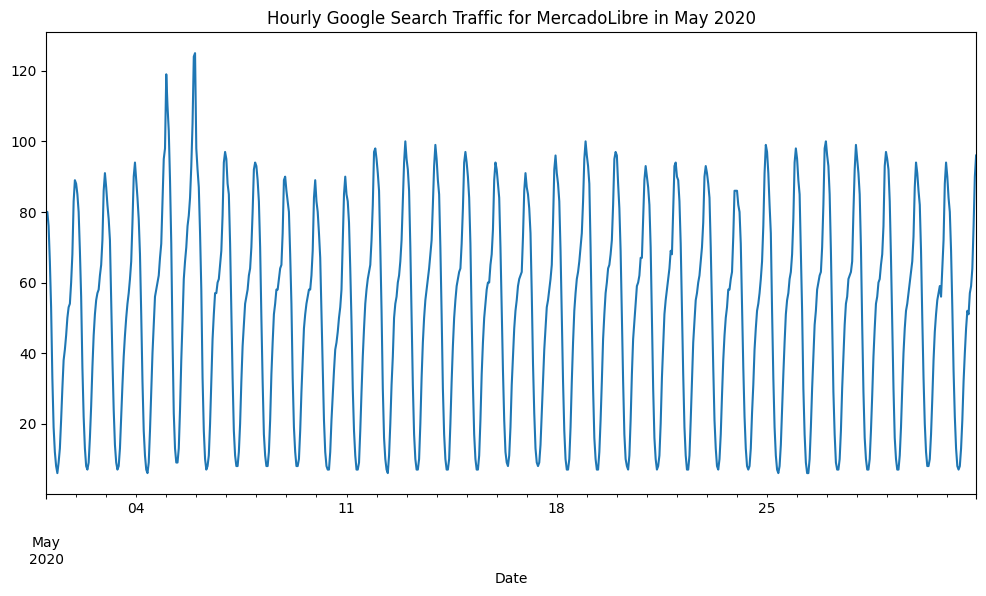

In [66]:
# Create a period representing May 2020
may_2020_period = pd.Period('2020-05')

# Slice the DataFrame to just the month of May 2020 using the period
df_may_2020 = df_mercado_trends[df_mercado_trends.index.to_period('M') == may_2020_period]

# Plot to visualize the data for May 2020
df_may_2020['Search Trends'].plot(figsize=(12, 6), title='Hourly Google Search Traffic for MercadoLibre in May 2020')

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [67]:
# Calculate the sum of the total search traffic for May 2020
total_search_traffic_may_2020 = df_may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
print("Total search traffic for May 2020:", total_search_traffic_may_2020)

Total search traffic for May 2020: 38181


In [68]:
# Calcluate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions

# Calculate the monthly median search traffic across all months
monthly_median_traffic = df_mercado_trends['Search Trends'].groupby([df_mercado_trends.index.year, df_mercado_trends.index.month]).sum().median()

# View the median_monthly_traffic value
print("Monthly median search traffic across all months:", monthly_median_traffic)

Monthly median search traffic across all months: 35172.5


In [69]:
# Calculate the search traffic for the month of May 2020
traffic_may_2020 = df_mercado_trends['Search Trends']['2020-05'].sum()

# Compare the search traffic for the month of May 2020 to the overall monthly median value
comparison_ratio = traffic_may_2020 / monthly_median_traffic

# View the comparison ratio
print("Comparison ratio of search traffic for May 2020 to overall monthly median value:", comparison_ratio)

Comparison ratio of search traffic for May 2020 to overall monthly median value: 1.0855355746677091


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, the search traffic for May 2020 is higher than the monthly median value across all months, indicating an increase in search traffic during May 2020 when the financial results were released. The comparison ratio of 1.0855 also confirms this increase.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

<Axes: xlabel='Date'>

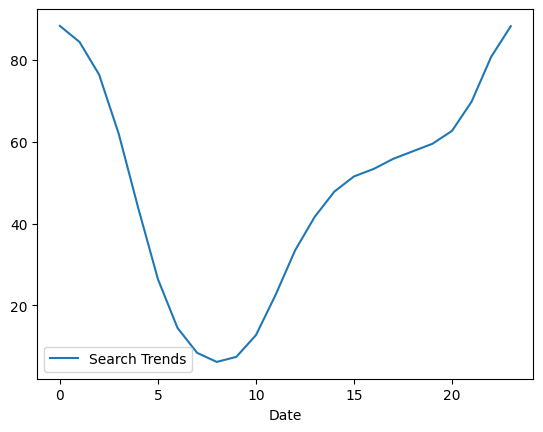

In [70]:
# Group the hourly search data by the day of the week using df.index.hour
df_mercado_trends.groupby(df_mercado_trends.index.hour).mean().plot()

# Calculate the average search traffic for each day of the week
#average_traffic_by_day = df_mercado_trends['Search Trends'].groupby(df_mercado_trends['DayOfWeek']).mean()

# Plot the average search traffic by day of the week
#average_traffic_by_day.plot(figsize=(12, 6), title='Average Hourly Google Search Traffic by Day of the Week')


#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

<Axes: xlabel='day'>

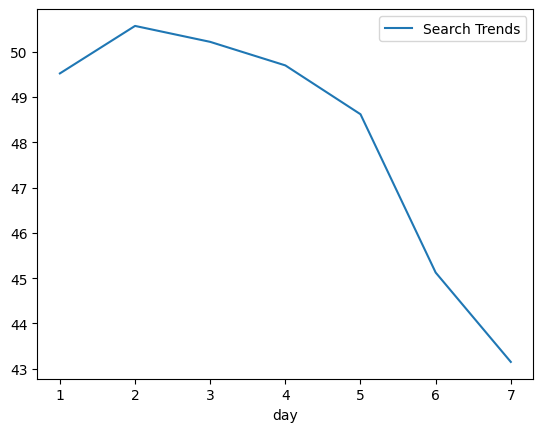

In [73]:
# Group the hourly search data by the day of the week using df.index.isocalendar().day
df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day).mean().plot()

# Calculate the average search traffic for each day of the week
#average_traffic_by_day_iso = df_mercado_trends['Search Trends'].groupby(df_mercado_trends['DayOfWeek_ISO']).mean()

# Plot the average search traffic by day of the week
#average_traffic_by_day_iso.plot(figsize=(12, 6), title='Average Hourly Google Search Traffic by Day of the Week (ISO)')

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

<Axes: xlabel='week'>

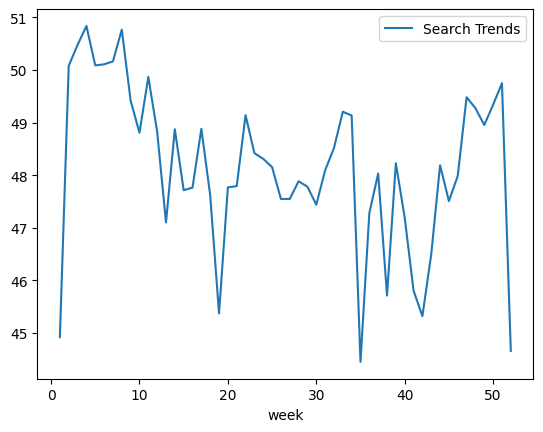

In [74]:
# Group the hourly search data by the week of the year using df.index.isocalendar().week
df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean().plot()

# Calculate the average search traffic for each week of the year
#average_traffic_by_week = df_mercado_trends['Search Trends'].groupby(df_mercado_trends['WeekOfYear']).mean()

# Plot the average search traffic by week of the year
#average_traffic_by_week.plot(figsize=(12, 6), title='Average Hourly Google Search Traffic by Week of the Year')

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** More searches tend to happen as the typical "work day" progresses with more searches happening early in the week.  More searches happen in the beginning of the year vs as the year progresses.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [32]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


<Axes: title={'center': 'MercadoLibre Stock Closing Price'}, xlabel='date'>

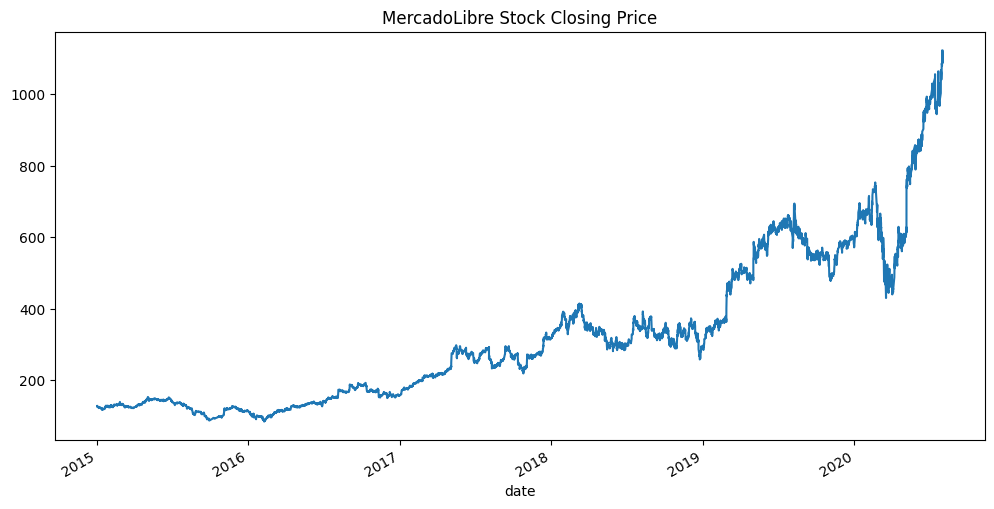

In [33]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock['close'].plot(figsize=(12, 6), title='MercadoLibre Stock Closing Price')

In [34]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
combined_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(combined_df.head())
display(combined_df.tail())


,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [35]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = combined_df['2020-01':'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


array([<Axes: >, <Axes: >], dtype=object)

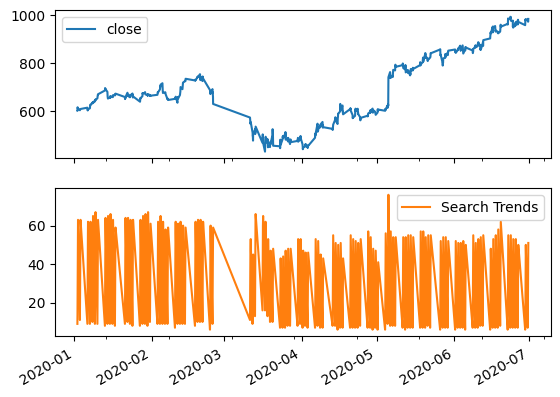

In [38]:
first_half_2020.plot(subplots=True)

In [39]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`

#import matplotlib.pyplot as plt

# Create a figure and axes for plotting
#fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot the close price on the first subplot
#combined_df['close'].plot(ax=ax[0], title='MercadoLibre Stock Closing Price')

# Plot the search trends on the second subplot
#combined_df['Search Trends'].plot(ax=ax[1], title='Hourly Google Search Traffic for MercadoLibre')

# Set the overall title for the figure
#fig.suptitle('Close Price and Search Trends Data')

# Show the plots
#plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Yes. Market price rose in 2020 with what looks to be beginning in May, when the financial information was released. Market price appears to be trending upward.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [41]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour

# Shift the Search Trends data by one hour and create a new column called "Lagged Search Trends"
combined_df['Lagged Search Trends'] = combined_df['Search Trends'].shift(1)

# Display the first and last five rows of the DataFrame to verify the new column
display(combined_df.head())
display(combined_df.tail())



,close,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,135.16,6.0,NaN
2016-06-01 10:00:00,136.63,12.0,6.0
2016-06-01 11:00:00,136.56,22.0,12.0
2016-06-01 12:00:00,136.42,33.0,22.0
2016-06-01 13:00:00,136.10,40.0,33.0


,close,Search Trends,Lagged Search Trends
2020-07-31 11:00:00,1105.780,20.0,11.0
2020-07-31 12:00:00,1087.925,32.0,20.0
2020-07-31 13:00:00,1095.800,41.0,32.0
2020-07-31 14:00:00,1110.650,47.0,41.0
2020-07-31 15:00:00,1122.510,53.0,47.0


In [42]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

# Calculate the stock price return
combined_df['Stock Return'] = combined_df['close'].pct_change()

# Calculate the Stock Volatility using a 4-period rolling window
combined_df['Stock Volatility'] = combined_df['Stock Return'].rolling(window=4).std()

# Display the first and last five rows of the DataFrame to verify the new column
display(combined_df.head())
display(combined_df.tail())


,close,Search Trends,Lagged Search Trends,Stock Return,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,0.010876,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,-0.000512,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,-0.001025,NaN
2016-06-01 13:00:00,136.10,40.0,33.0,-0.002346,0.006134


,close,Search Trends,Lagged Search Trends,Stock Return,Stock Volatility
2020-07-31 11:00:00,1105.780,20.0,11.0,0.006380,0.012837
2020-07-31 12:00:00,1087.925,32.0,20.0,-0.016147,0.013549
2020-07-31 13:00:00,1095.800,41.0,32.0,0.007239,0.013295
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013552,0.013001
2020-07-31 15:00:00,1122.510,53.0,47.0,0.010678,0.013566


<Axes: >

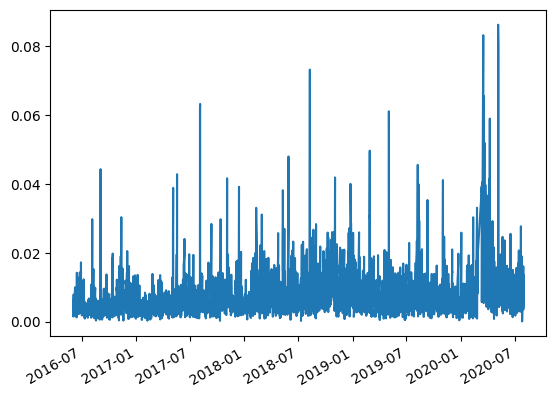

In [43]:
# Visualize the stock volatility
combined_df['Stock Volatility'].plot()

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [44]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

# Calculate the hourly stock return percentage
combined_df['Hourly Stock Return'] = combined_df['close'].pct_change()

# Display the first and last five rows of the DataFrame to verify the new column
display(combined_df.head())
display(combined_df.tail())


,close,Search Trends,Lagged Search Trends,Stock Return,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,0.010876,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,-0.000512,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,-0.001025,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,-0.002346,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Return,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.006380,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,-0.016147,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.007239,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013552,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.010678,0.013566,0.010678


In [45]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame

# View the first five rows of the DataFrame
display(combined_df.head())

# View the last five rows of the DataFrame
display(combined_df.tail())

,close,Search Trends,Lagged Search Trends,Stock Return,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,0.010876,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,-0.000512,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,-0.001025,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,-0.002346,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Return,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.006380,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,-0.016147,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.007239,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013552,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.010678,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [46]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
#mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

# Select the columns of interest for the correlation analysis
correlation_cols = ['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']

# Calculate the correlation matrix
correlation_matrix = combined_df[correlation_cols].corr()

# Display the correlation matrix
print(correlation_matrix)

                      Stock Volatility  Lagged Search Trends  \
Stock Volatility              1.000000             -0.148938   
Lagged Search Trends         -0.148938              1.000000   
Hourly Stock Return           0.061424              0.017929   

                      Hourly Stock Return  
Stock Volatility                 0.061424  
Lagged Search Trends             0.017929  
Hourly Stock Return              1.000000  


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** Based on the correlation values provided, it appears that there is a weak negative relationship between lagged search trends and stock volatility (-0.148938), and a very weak positive relationship between lagged search trends and hourly stock return (0.017929).

These correlation values suggest that there may be some very limited predictability between lagged search traffic and stock volatility or stock price returns, but the relationships are not strong. It is important to note that correlation does not imply causation, so further analysis would be needed to determine if there is a truly predictable relationship between these variables.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [47]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
df_mercado_trends.reset_index(inplace=True)

# Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df = df_mercado_trends.rename(columns={'Date': 'ds', 'Search Trends': 'y'})

# Drop any NaN values from the prophet_df DataFrame
prophet_df.dropna(inplace=True)

# View the first and last five rows of the mercado_prophet_df DataFrame
display(prophet_df.head())
display(prophet_df.tail())


,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [48]:
# Call the Prophet function and store it as an object
model = Prophet()

# Fit the model on the prophet_df DataFrame
model.fit(prophet_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcjzfguqj/0he_rrpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcjzfguqj/zpucvvei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58027', 'data', 'file=/tmp/tmpcjzfguqj/0he_rrpe.json', 'init=/tmp/tmpcjzfguqj/zpucvvei.json', 'output', 'file=/tmp/tmpcjzfguqj/prophet_modelbvw27ho5/prophet_model-20240903183459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


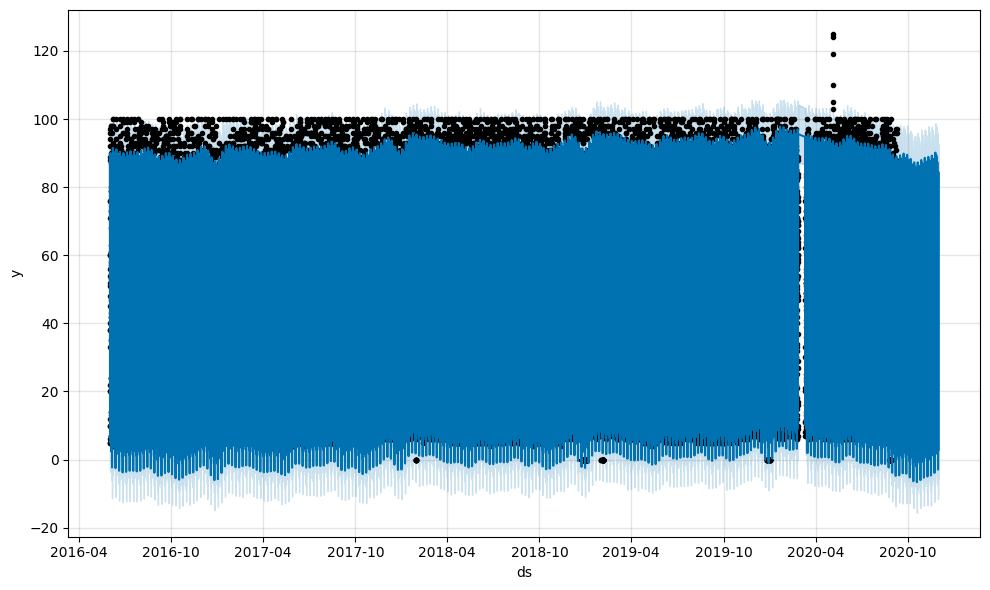

In [52]:
# Fit the time-series model.

# Make a future dataframe for forecasting
future = model.make_future_dataframe(periods=2000,freq='H')

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

# Show the plot
plt.show()


In [54]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
#future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
#display(future_mercado_trends.tail())

In [56]:
# Make predictions for the trend data using the future_mercado_trends DataFrame
#forecast_mercado_trends = model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
#display(forecast_mercado_trends.head())


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

In [57]:
# Plot the Prophet predictions for the Mercado trends data
#fig = model.plot(forecast_mercado_trends)
#plt.title('Prophet Predictions for Mercado Trends Data')
#plt.xlabel('Date')
#plt.ylabel('Search Trends')
#plt.show()


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** It seems that there is a subtle trend downward.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [58]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index('ds', inplace=True)

# View only the yhat, yhat_lower, and yhat_upper columns from the DataFrame
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.629222,81.348119,97.765340
2016-06-01 01:00:00,86.075935,78.119779,95.114088
2016-06-01 02:00:00,75.753361,66.828190,84.286352
2016-06-01 03:00:00,60.487045,51.675055,68.813911
2016-06-01 04:00:00,43.373051,33.851288,51.971480
...,...,...,...
2020-11-30 04:00:00,39.781638,31.163644,48.230978
2020-11-30 05:00:00,24.310504,16.409624,32.380025
2020-11-30 06:00:00,12.344836,3.472435,20.924887


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

<Axes: xlabel='ds'>

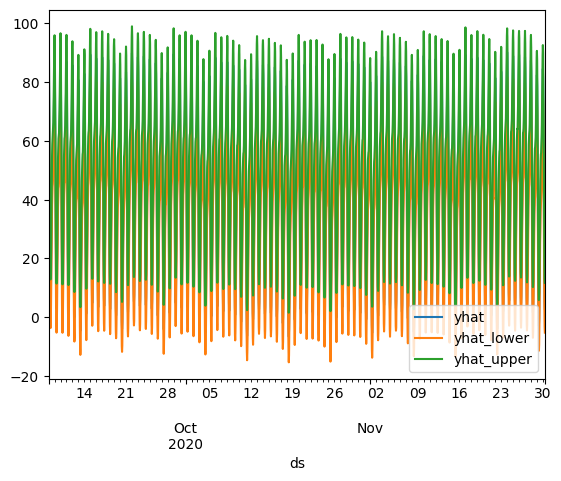

In [61]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours

forecast_mercado_trends[['yhat','yhat_lower','yhat_upper']].iloc[-2000:,:].plot()


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

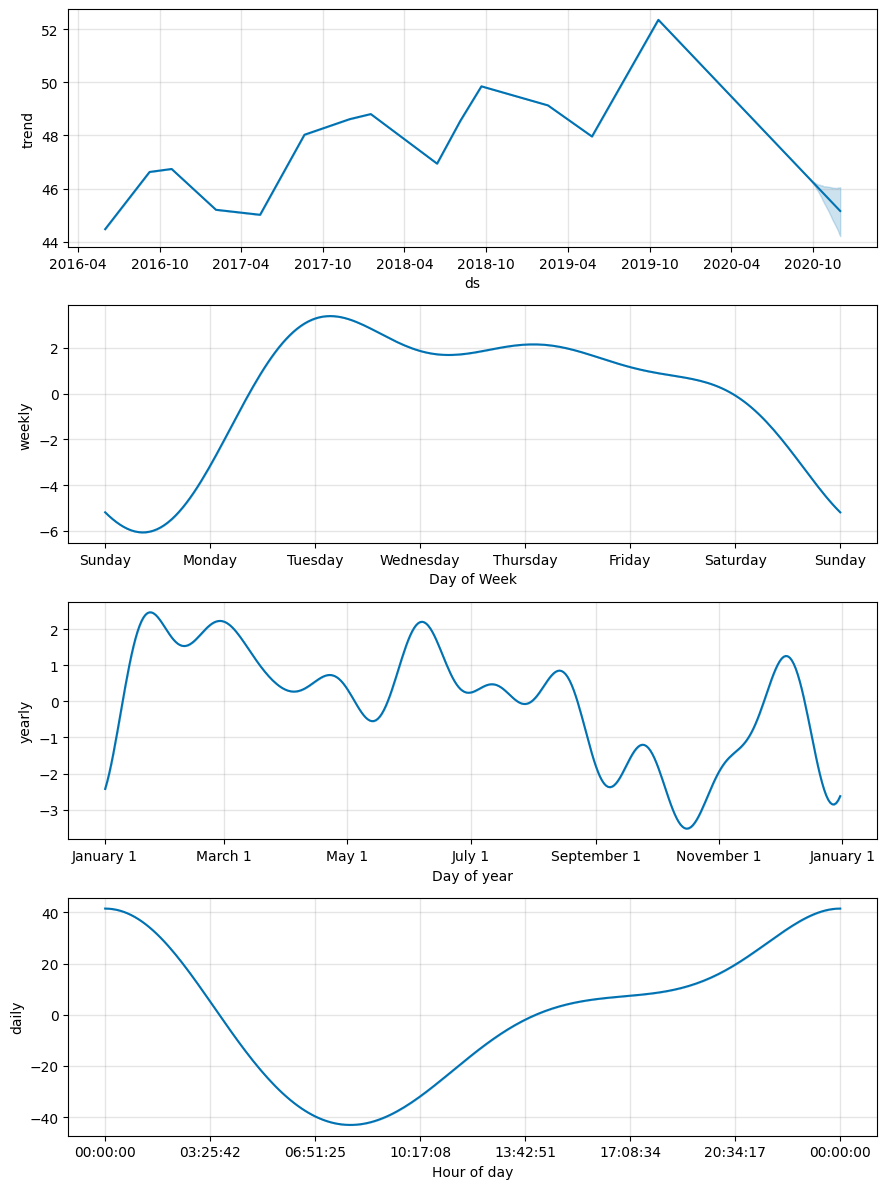

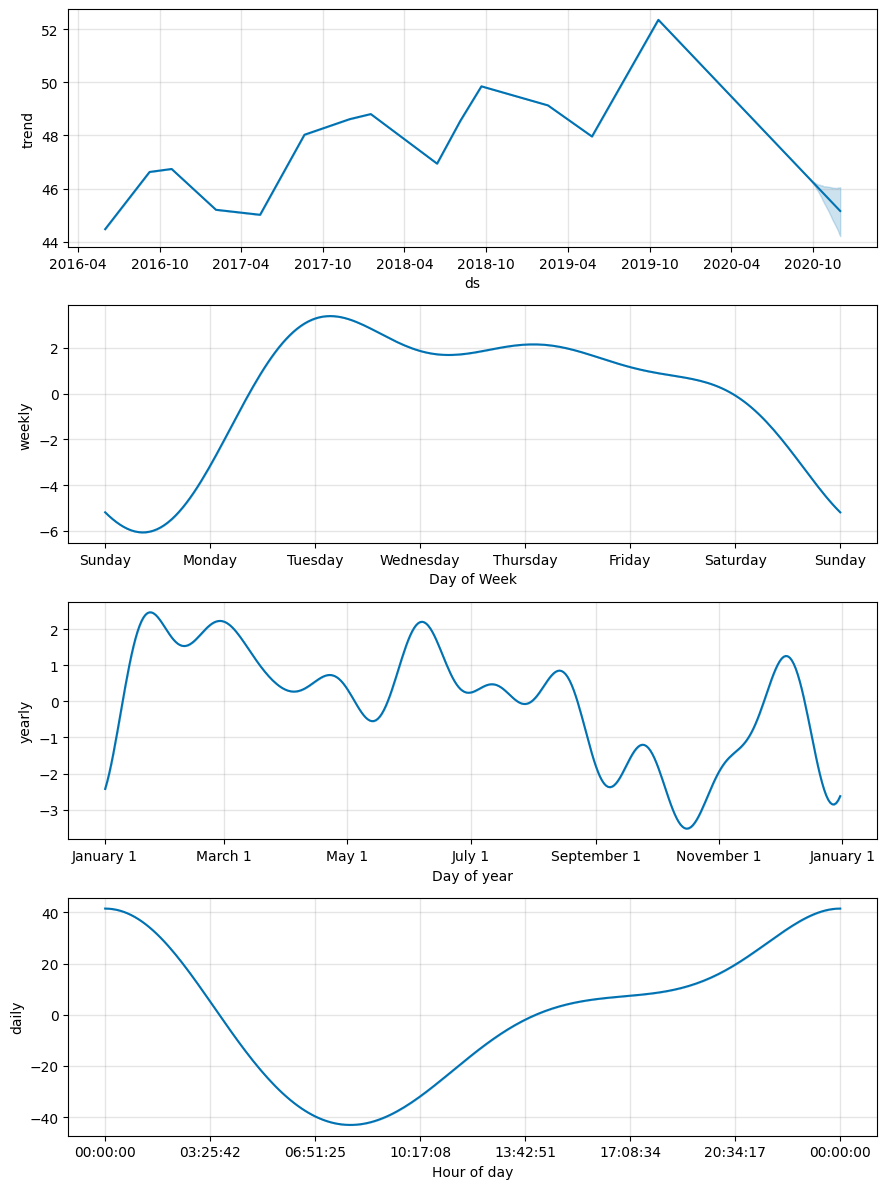

In [62]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
model.plot_components(forecast_mercado_trends)

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Evening hours have the most visits peaking at mindnight

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** Late October just before November.